## Mini model
How quickly does model leanr? Implication of task difficulty in CIFAKE?

train on dev data
train on 1 batch of train data

In [1]:
## Imports
import json
import torch

from classes import  CI_LOADER, CIFAKE_CNN, get_files
from test import test_model, score_preds, test_thresh_size, visualise
from train import train_model

with open('./config.json') as f:
    config = json.load(f)

torch.manual_seed(11)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# load data
data = get_files(config['CIFAKE_dir'])
# Split data
trainfiles = data['train']
testfiles = data['test']

trainfiles[0]  # tuple of filepath + class as str
len(trainfiles), trainfiles[0]

(100000, ('../data/CIFAKE/train/REAL/1006 (3).jpg', 'REAL'))

In [3]:
traindata = CI_LOADER(trainfiles, batch_size=32)
testdata = CI_LOADER(testfiles, batch_size=32)
# 35s

In [4]:
tiny_traindata = CI_LOADER(trainfiles[:3456], batch_size=32)

In [5]:
tiny_model = CIFAKE_CNN()
tiny_model = train_model(tiny_model, tiny_traindata, epochs=1, learn_rate=0.001)

  0%|          | 0/108 [00:00<?, ?it/s]

epoch: 0	total loss: 74.80095064640045	avg loss: 0.6926013948740782
Finished Training


Eval of tiny (108 batches, a 32 imgs)

In [6]:
# instead: every x batches, compute acc on dev set & plot
# train loss v valid acc

  0%|          | 0/625 [00:00<?, ?it/s]

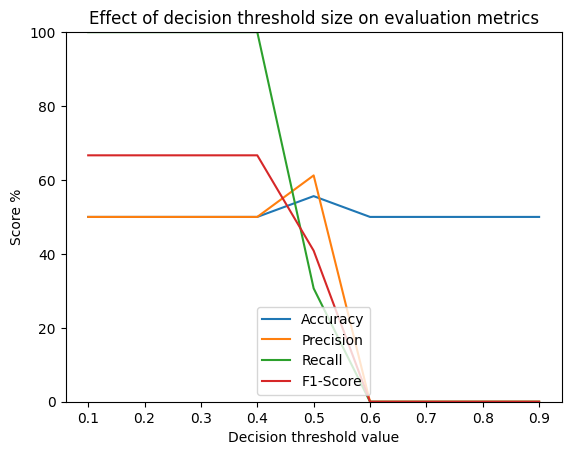

In [7]:
# testing
tiny_gold, tiny_preds = test_model(tiny_model, testdata)
tiny_df = test_thresh_size(tiny_gold, tiny_preds)
visualise(tiny_df)

In [8]:
tiny_df

,Accuracy,Precision,Recall,F1-Score
0.1,50.000,50.000000,100.00,66.666667
0.2,50.000,50.000000,100.00,66.666667
0.3,50.000,50.000000,100.00,66.666667
0.4,50.000,50.000000,100.00,66.666667
0.5,55.625,61.229786,30.67,40.868812
0.6,50.000,0.000000,0.00,0.000000
0.7,50.000,0.000000,0.00,0.000000
0.8,50.000,0.000000,0.00,0.000000
0.9,50.000,0.000000,0.00,0.000000


## Explore difficulty of task

Train CNN for 1 epoch & log tarin/validation loss + vallidation accuracy
every X batches to see when/how quickly model learns

In [10]:
len(traindata.batches)  # tiny was 108

3125

In [11]:
# split off some data to use as validation set
inc_devdata =  CI_LOADER(testfiles[:int(len(testfiles)*0.1)])
inc_testdata = CI_LOADER(testfiles[int(len(testfiles)*0.1):])

In [12]:
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
import torch.nn as nn

criterion_val = nn.BCELoss()

def acc_fcn(model, thresh=0.5):
    gold, preds = list(), list()
    tloss=0
    model.eval()
    with torch.no_grad():
        for batch in inc_devdata:
            X, y_true = batch
            # calculate outputs by running images through the network
            output = model(X)
            tloss += criterion_val(output, y_true.reshape(-1, 1)).item()  # reshape for single dim
            # Store true and predicted class labels
            gold.extend(list(np.array(y_true)))
            preds.extend(list(np.array(output.squeeze())))
    y_pred = [1 if pred >= thresh else 0 for pred in preds]
    acc = accuracy_score(gold, y_pred)
    model.train()

    return acc, tloss/len(inc_devdata.batches)


def log_train(model: CIFAKE_CNN, data: list[tuple], epochs: int = 5,
          learn_rate: float = 0.001, momentum: float = 0.9) -> CIFAKE_CNN:
    """Train and return CNN for binary image classification.

    Args:
        model (CIFAKE_CNN): CNN model structure
        data (list[tuple]): List of (filename, class label) items as str
        epochs (int, optional): Number of epochs. Defaults to 5.
        learn_rate (float, optional): Optimizer learn rate. Defaults to 0.001.
        momentum (float, optional): Momentum for optimizer. Defaults to 0.9.

    Returns:
        CIFAKE_CNN: CNN model for binary image classification
    """
    # own function, structure base from cifar10_tutorial.ipynb, but modified
    # everthing but the running_loss usage
    criterion = nn.BCELoss()  # match loss for binary classification
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)
    logs = dict()
    for epoch in range(epochs):
        total_loss = 0
        running_loss = 0
        tloss = 0
        for i, batch in tqdm(enumerate(data), total=len(data.batches)):
            # reset gradient
            optimizer.zero_grad()

            # Extract input and labels, make predictions
            X, y = batch
            output = model(X)

            # calculate & store loss
            loss = criterion(output, y.reshape(-1, 1))  # reshape for single dim
            running_loss += loss.item()
            total_loss += loss.item()
            tloss += loss.item()

            # backpropagate & update gradient
            loss.backward()
            optimizer.step()

            if i>0 and not i%5:
                logs[i] = dict()
                acc, l = acc_fcn(model)
                logs[i]['val_accuracy']  = acc
                logs[i]['val_loss'] = l
                logs[i]['train_loss'] = tloss/(5 if i>6 else 5+1)
                #total_loss/(i+1)
                #tloss/5+1
                tloss = 0
                #total_loss/(i+1)

            # print statistics
            if i % (len(data.batches)//4) == (len(data.batches)//4)-1:
                print(f'[{epoch+1}, {i+1:5d}] avg loss: {running_loss/(len(data.batches)//4):.3f}',
                      end='\r')  # kept from class notebook, udpated with n_batches
                running_loss = 0.0

        print(f'\repoch: {epoch}\ttotal loss: {total_loss}\tavg loss: {total_loss/len(data.batches)}')
        break
    print('Finished Training')

    return model, logs


In [13]:
mini_model = CIFAKE_CNN()
mini_model, accs = log_train(mini_model, traindata, epochs=1)

  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 1998.4665322899818	avg loss: 0.6395092903327942
Finished Training


In [63]:
# torch.save(mini_model.state_dict(), config['mini_model'])

In [20]:
mm = CIFAKE_CNN()
mm.load_state_dict(torch.load('../models/dummymodel.pth'))

<All keys matched successfully>

In [21]:
# predict labels
gold, preds = test_model(mm, testdata)
# evaluate with accuracy, precision, recall, f1-score
eval = score_preds(gold, preds, verbose=True)

  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 50.00%

              score
precision  0.500000
recall     0.999900
f1-score   0.666644


eval

In [50]:
mini_model = CIFAKE_CNN()
mini_model.load_state_dict(torch.load(config['mini_model']))

<All keys matched successfully>

In [51]:
# predict labels
gold, preds = test_model(mini_model, testdata)
# evaluate with accuracy, precision, recall, f1-score
eval = score_preds(gold, preds, verbose=True)

  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 76.57%

              score
precision  0.709322
recall     0.900200
f1-score   0.793442


In [52]:
import pandas as pd
train_progress = pd.DataFrame(accs)
train_progress

,5,10,15,20,25,30,35,40,45,50,...,3075,3080,3085,3090,3095,3100,3105,3110,3115,3120
val_accuracy,0.500000,0.500504,0.501512,0.501512,0.501512,0.501512,0.501512,0.502016,0.502520,0.502520,...,0.739415,0.773185,0.787298,0.787802,0.776210,0.784778,0.784274,0.772681,0.781754,0.783770
val_loss,0.693399,0.693384,0.693365,0.693344,0.693328,0.693312,0.693293,0.693272,0.693252,0.693229,...,0.503731,0.476895,0.465579,0.454656,0.462761,0.457011,0.454110,0.463749,0.455094,0.451598
train_loss,0.693399,0.692279,0.693084,0.693889,0.693827,0.692663,0.692731,0.692947,0.693017,0.693042,...,0.515509,0.414638,0.428314,0.504918,0.511362,0.385095,0.447699,0.466853,0.507970,0.454694


<Axes: xlabel='Number of batches (size 32) seen'>

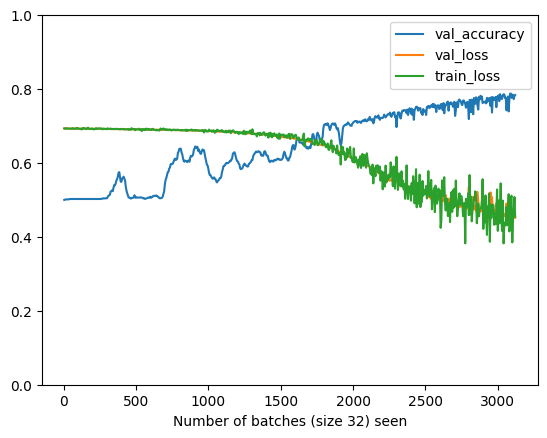

In [59]:
train_progress.transpose().plot(ylim=(0,1), xlabel='Number of batches (size 32) seen')

In [54]:
gold, preds = test_model(mini_model, testdata)
scores = score_preds(gold, preds, verbose=True, per_class=True)

  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 76.57%

               Fake      Real   Average
precision  0.863456  0.709322  0.786389
recall     0.631100  0.900200  0.765650
f1-score   0.729216  0.793442  0.761329


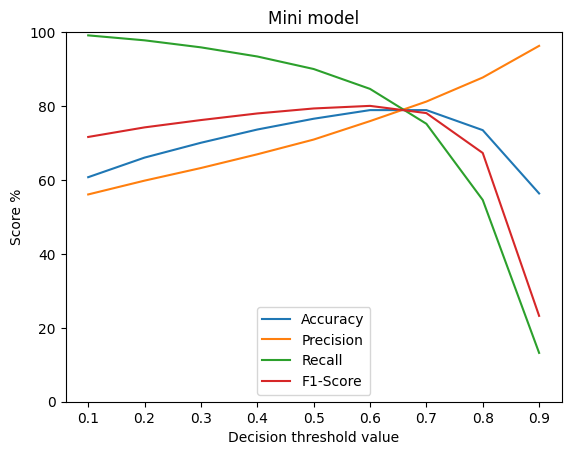

In [62]:
df = test_thresh_size(gold, preds)
visualise(df, title='Mini model')